In [14]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN1
import PIL
from torchvision.transforms import ToPILImage
from IPython.display import display
import zlib
import matplotlib.pyplot as plt

In [15]:
checkpoint = torch.load("checkpoint_dino_rdae_5.pth", map_location={'cuda:0': 'cpu'})
d = checkpoint['distortion']
r = checkpoint['rate']

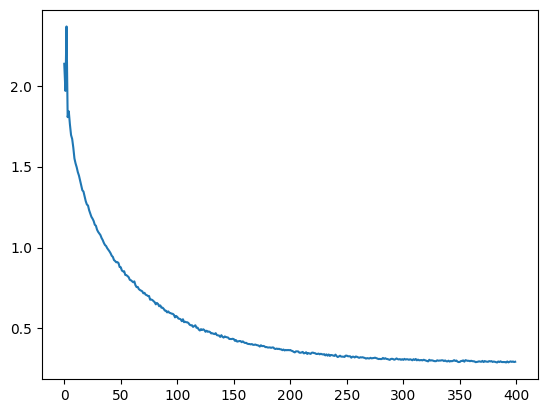

In [16]:
plt.plot(d)

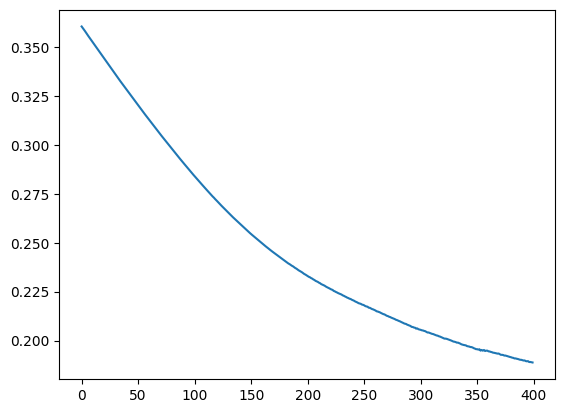

In [17]:
plt.plot(r)

In [18]:
imagenet_valid = load_dataset("danjacobellis/imagenet_dino",split='validation').with_format("torch")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [19]:
def conv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        groups=groups
    )

In [20]:
def deconv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
        groups=groups
    )

In [21]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=4096):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(1536, N, kernel_size=1, stride=1),
            GDN1(N),
            conv(N, N, kernel_size=5, stride=2),
            # GDN1(N),
            # conv(N, N, kernel_size=5, stride=2),
        )

        self.decode = nn.Sequential(
            # deconv(N, N, kernel_size=5, stride=2),
            # GDN1(N, inverse=True),
            deconv(N, N, kernel_size=5, stride=2),
            GDN1(N, inverse=True),
            deconv(N, 1536, kernel_size=1, stride=1),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [22]:
net = RateDistortionAutoEncoder()
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
x = imagenet_valid[0]['patch_tokens'].reshape((1,16,16,1536)).permute((0,3,1,2))

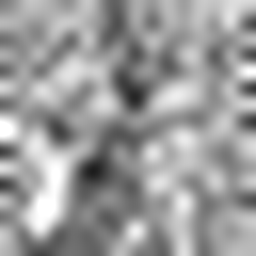

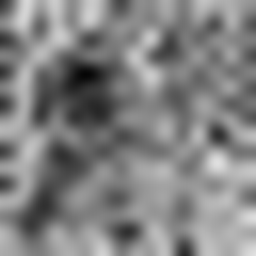

In [24]:
for c in range(2):
    z = x[0,c,:,:]
    z = z.clamp(-3,3)
    z = z/6 + 0.5
    z = (255*z).round().to(torch.uint8)
    display(ToPILImage()(z).resize((256,256),resample=PIL.Image.Resampling.LANCZOS))

In [25]:
y = net.encode(x)
y = y.round()
y = y.clamp(-128,127)
y = y.to(torch.int8)
y = y.numpy()
original_shape = y.shape
compressed = zlib.compress(y.tobytes(), level=9)
ratio = (1536*16*16*32)/(8*len(compressed))
print("Compression ratio",ratio)
decompressed = zlib.decompress(compressed)
y = np.frombuffer(decompressed, dtype=np.int8)
y = y.reshape(original_shape)
y = torch.tensor(y)
y = y.to(torch.float)
x_hat = net.decode(y)

Compression ratio 15.198368908772913


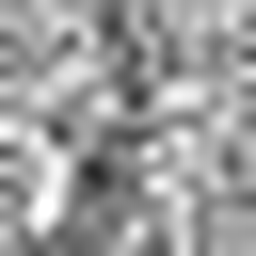

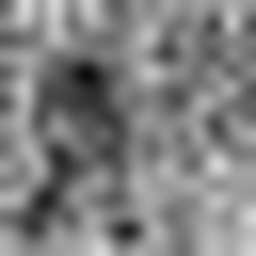

In [26]:
for c in range(2):
    z = x_hat[0,c,:,:]
    z = z.clamp(-3,3)
    z = z/6 + 0.5
    z = (255*z).round().to(torch.uint8)
    display(ToPILImage()(z).resize((256,256),resample=PIL.Image.Resampling.LANCZOS))